# Generate and explore BA-Shapes dataset

In [103]:
# # Following the recommended way to generate the BA-shapes according to torch_geometric
# import torch
# from torch_geometric.datasets import ExplainerDataset
# from torch_geometric.datasets.graph_generator import BAGraph
# import torch_geometric.transforms as T
# from torch_geometric.utils import degree

# dataset = ExplainerDataset(
#     graph_generator=BAGraph(num_nodes=300, num_edges=3),
#     motif_generator='house',
#     num_motifs=80,
# )
# data = dataset[0]
# max_degree = degree(data.edge_index[0], num_nodes=data.num_nodes, dtype=torch.long).max().item()
# T.OneHotDegree(max_degree)(data)

Explanation(edge_index=[2, 2852], y=[700], edge_mask=[2852], node_mask=[700], x=[700, 50])

In [104]:
# # Train test split
# from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets
# idx = torch.arange(data.num_nodes)
# idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=42, stratify=data.y)
# data.idx_train = idx_train
# data.idx_test = idx_test

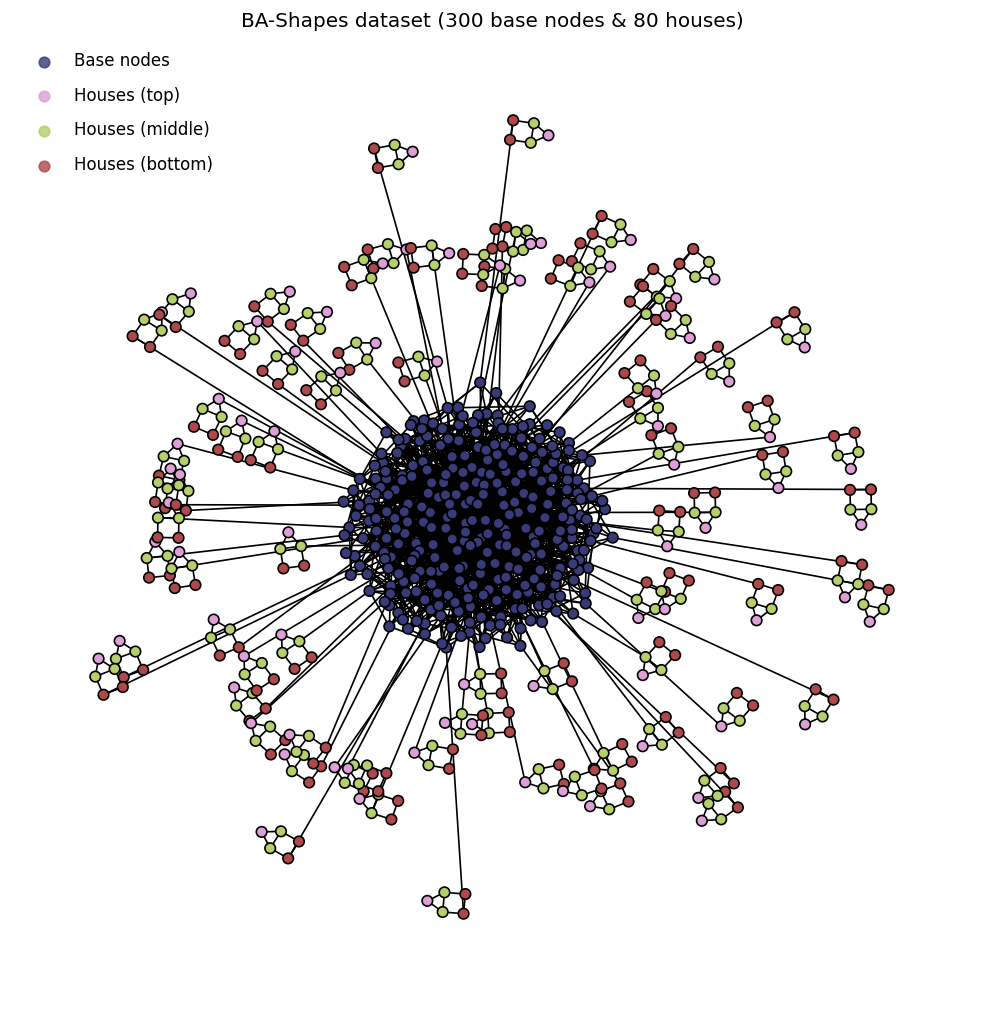

In [27]:
# # Some utility functions to visualize the BA-Shapes dataset more properly
# import numpy as np
# import matplotlib.pyplot as plt
# from torch_geometric.utils import to_networkx
# import networkx as nx

# def rotate_vector(vector: np.array, theta: float) -> np.array:
#     rot_matrix = np.array(
#         [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
#     )
#     return np.matmul(rot_matrix, vector)


# def get_theta(position: np.array) -> float:
#     return np.arctan2(position[0], position[1])


# def get_relative_position_with_rotation(anchor_position: np.array) -> tuple:
#     rel_pos1 = [0.0157452, 0.04893756]
#     rel_pos2 = [-0.03321002, 0.06469372]
#     rel_pos3 = [-0.04895832, 0.01574654]
#     rel_pos4 = [0.04589422, 0.01223573]

#     theta = -get_theta(position=anchor_position) + 0.3

#     rel_pos1 = rotate_vector(vector=rel_pos1, theta=theta)
#     rel_pos2 = rotate_vector(vector=rel_pos2, theta=theta)
#     rel_pos3 = rotate_vector(vector=rel_pos3, theta=theta)
#     rel_pos4 = rotate_vector(vector=rel_pos4, theta=theta)

#     return rel_pos1, rel_pos2, rel_pos3, rel_pos4


# data_nx = to_networkx(data, to_undirected=True)  # Transform to a networkx object
# pos = nx.kamada_kawai_layout(data_nx)  # Get node positions before drawing

# for first_node in range(300, 700, 5):
#     anchor_position = pos[first_node]
#     # Rotate position of each house according to their position for better visualization
#     rel_pos1, rel_pos2, rel_pos3, rel_pos4 = get_relative_position_with_rotation(
#         anchor_position=anchor_position
#     )
#     pos[first_node + 1] = anchor_position + rel_pos1
#     pos[first_node + 2] = anchor_position + rel_pos2
#     pos[first_node + 3] = anchor_position + rel_pos3
#     pos[first_node + 4] = anchor_position + rel_pos4

# # Set colormap
# cmap = plt.cm.tab20b
# # Draw the graph
# plt.figure(figsize=(8, 8), dpi=120)
# nx.draw(
#     data_nx,
#     node_size=40,
#     cmap=cmap,
#     node_color=data.y / 3,
#     pos=pos,
#     edgecolors="black",
# )
# # legend
# plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Base nodes")
# plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.9999), label="Houses (top)")
# plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.3333), label="Houses (middle)")
# plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6667), label="Houses (bottom)")
# plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper left")
# plt.title(
#     "BA-Shapes dataset (300 base nodes & 80 houses)"
# )
# plt.show()


In [105]:
# # Save data as local (for reproducibility)
# torch.save(data, '/workspace/BA-Shapes.pt')

In [118]:
"""
Define a function that trains the GAT model for a given number of epochs.
The function takes as input the model, the dataset, the optimizer, the number of epochs.
We perform full-batch training.
The function returns the trained model and the training loss, and the training accuracy.
"""
import torch

def train(model, data, optimizer, epochs: int):
    # Set the model to training mode
    model.train()
    # Define the criterion
    criterion = torch.nn.CrossEntropyLoss()
    # Full batch training
    for _ in range(epochs):
        # Zero out the gradients
        optimizer.zero_grad()
        # Perform the forward pass
        out = model(data.x, data.edge_index)
        # Compute the loss
        loss = criterion(out[data.idx_train], data.y[data.idx_train])
        # Compute the accuracy
        acc = (out[data.idx_train].argmax(dim=1) == data.y[data.idx_train]).sum().item() / len(data.idx_train)
        # Perform the backward pass
        loss.backward()
        # Perform the optimization step
        optimizer.step()
    return model, loss, acc

"""
Make a function that tests the GAT model.
Use the test mask to only compute the loss and accuracy for the test nodes.
The function takes as input the model and the dataset.
"""
@torch.no_grad()
def test(model, data):
    # Set the model to evaluation mode
    model.eval()
    # Define the test loss
    loss = 0
    # Define the test accuracy
    acc = 0
    # Define the criterion
    criterion = torch.nn.CrossEntropyLoss()
    # Get the test data
    x, edge_index, y = data.x, data.edge_index, data.y
    # Get the output of the model
    out = model(x, edge_index)
    # Compute the loss
    loss = criterion(out[data.idx_test], y[data.idx_test])
    # Compute the test accuracy
    acc = (out[data.idx_test].argmax(dim=1) == y[data.idx_test]).sum().item() / len(data.idx_test)
    # Return the test loss and the test accuracy
    return loss, acc

In [201]:
# # Train GAT models on the BA-Shapes dataset
# from models import GAT_L2_intervention, GAT_L3_intervention

# # Enable GPU device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load dataset from local
# data = torch.load('/workspace/BA-Shapes.pt').to(device)

# out_channels = data.y.max().item() + 1

# # Define several GAT models with 1, 2, 4, 8 attention heads to be used for 'data.pt', and move them to the GPU device (if available)
# model1_L2 = GAT_L2_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=1)
# model2_L2 = GAT_L2_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=2)
# model4_L2 = GAT_L2_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=4)
# model8_L2 = GAT_L2_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=8)
# model1_L3 = GAT_L3_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=1)
# model2_L3 = GAT_L3_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=2)
# model4_L3 = GAT_L3_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=4)
# model8_L3 = GAT_L3_intervention(in_channels=data.num_node_features, hidden_channels=16, out_channels=out_channels, heads=8)

# # Move the models to the GPU device (if available)
# model1_L2 = model1_L2.to(device)
# model2_L2 = model2_L2.to(device)
# model4_L2 = model4_L2.to(device)
# model8_L2 = model8_L2.to(device)
# model1_L3 = model1_L3.to(device)
# model2_L3 = model2_L3.to(device)
# model4_L3 = model4_L3.to(device)
# model8_L3 = model8_L3.to(device)

# """
# Now we can train all the models and compare their performance.
# Keep the number of epochs and the learning rate the same for all the models.
# """

# # Define the number of epochs
# epochs = 1000
# # Define the learning rate
# lr = 0.01
# # Prepare the optimizer
# optimizer1_L2 = torch.optim.Adam(model1_L2.parameters(), lr=lr, weight_decay=0)
# optimizer2_L2 = torch.optim.Adam(model2_L2.parameters(), lr=lr, weight_decay=0)
# optimizer4_L2 = torch.optim.Adam(model4_L2.parameters(), lr=lr, weight_decay=0)
# optimizer8_L2 = torch.optim.Adam(model8_L2.parameters(), lr=lr, weight_decay=0)
# optimizer1_L3 = torch.optim.Adam(model1_L3.parameters(), lr=lr, weight_decay=0)
# optimizer2_L3 = torch.optim.Adam(model2_L3.parameters(), lr=lr, weight_decay=0)
# optimizer4_L3 = torch.optim.Adam(model4_L3.parameters(), lr=lr, weight_decay=0)
# optimizer8_L3 = torch.optim.Adam(model8_L3.parameters(), lr=lr, weight_decay=0)

# # Train the models
# model1_L2, loss1_L2, acc1_L2 = train(model=model1_L2, data=data, optimizer=optimizer1_L2, epochs=epochs)
# model2_L2, loss2_L2, acc2_L2 = train(model=model2_L2, data=data, optimizer=optimizer2_L2, epochs=epochs)
# model4_L2, loss4_L2, acc4_L2 = train(model=model4_L2, data=data, optimizer=optimizer4_L2, epochs=epochs)
# model8_L2, loss8_L2, acc8_L2 = train(model=model8_L2, data=data, optimizer=optimizer8_L2, epochs=epochs)
# model1_L3, loss1_L3, acc1_L3 = train(model=model1_L3, data=data, optimizer=optimizer1_L3, epochs=epochs)
# model2_L3, loss2_L3, acc2_L3 = train(model=model2_L3, data=data, optimizer=optimizer2_L3, epochs=epochs)
# model4_L3, loss4_L3, acc4_L3 = train(model=model4_L3, data=data, optimizer=optimizer4_L3, epochs=epochs)
# model8_L3, loss8_L3, acc8_L3 = train(model=model8_L3, data=data, optimizer=optimizer8_L3, epochs=epochs)

# # Test the models
# test_loss1_L2, test_acc1_L2 = test(model=model1_L2, data=data)
# test_loss2_L2, test_acc2_L2 = test(model=model2_L2, data=data)
# test_loss4_L2, test_acc4_L2 = test(model=model4_L2, data=data)
# test_loss8_L2, test_acc8_L2 = test(model=model8_L2, data=data)
# test_loss1_L3, test_acc1_L3 = test(model=model1_L3, data=data)
# test_loss2_L3, test_acc2_L3 = test(model=model2_L3, data=data)
# test_loss4_L3, test_acc4_L3 = test(model=model4_L3, data=data)
# test_loss8_L3, test_acc8_L3 = test(model=model8_L3, data=data)

# # Print the results
# print(f"Model: GAT_BAShapes_2L1H, Loss: {loss1_L2:.4f}, Train Accuracy: {acc1_L2:.4f}, Test Loss: {test_loss1_L2:.4f}, Test Accuracy: {test_acc1_L2:.4f}")
# print(f"Model: GAT_BAShapes_2L2H, Loss: {loss2_L2:.4f}, Train Accuracy: {acc2_L2:.4f}, Test Loss: {test_loss2_L2:.4f}, Test Accuracy: {test_acc2_L2:.4f}")
# print(f"Model: GAT_BAShapes_2L4H, Loss: {loss4_L2:.4f}, Train Accuracy: {acc4_L2:.4f}, Test Loss: {test_loss4_L2:.4f}, Test Accuracy: {test_acc4_L2:.4f}")
# print(f"Model: GAT_BAShapes_2L8H, Loss: {loss8_L2:.4f}, Train Accuracy: {acc8_L2:.4f}, Test Loss: {test_loss8_L2:.4f}, Test Accuracy: {test_acc8_L2:.4f}")
# print(f"Model: GAT_BAShapes_3L1H, Loss: {loss1_L3:.4f}, Train Accuracy: {acc1_L3:.4f}, Test Loss: {test_loss1_L3:.4f}, Test Accuracy: {test_acc1_L3:.4f}")
# print(f"Model: GAT_BAShapes_3L2H, Loss: {loss2_L3:.4f}, Train Accuracy: {acc2_L3:.4f}, Test Loss: {test_loss2_L3:.4f}, Test Accuracy: {test_acc2_L3:.4f}")
# print(f"Model: GAT_BAShapes_3L4H, Loss: {loss4_L3:.4f}, Train Accuracy: {acc4_L3:.4f}, Test Loss: {test_loss4_L3:.4f}, Test Accuracy: {test_acc4_L3:.4f}")
# print(f"Model: GAT_BAShapes_3L8H, Loss: {loss8_L3:.4f}, Train Accuracy: {acc8_L3:.4f}, Test Loss: {test_loss8_L3:.4f}, Test Accuracy: {test_acc8_L3:.4f}")

Model: GAT_BAShapes_2L1H, Loss: 0.1243, Train Accuracy: 0.9679, Test Loss: 0.1822, Test Accuracy: 0.9500
Model: GAT_BAShapes_2L2H, Loss: 0.1617, Train Accuracy: 0.9321, Test Loss: 0.3828, Test Accuracy: 0.9000
Model: GAT_BAShapes_2L4H, Loss: 0.2002, Train Accuracy: 0.8893, Test Loss: 0.2756, Test Accuracy: 0.8857
Model: GAT_BAShapes_2L8H, Loss: 0.1660, Train Accuracy: 0.9054, Test Loss: 0.1918, Test Accuracy: 0.8786
Model: GAT_BAShapes_3L1H, Loss: 0.0169, Train Accuracy: 0.9982, Test Loss: 0.1833, Test Accuracy: 0.9571
Model: GAT_BAShapes_3L2H, Loss: 0.2482, Train Accuracy: 0.8518, Test Loss: 0.2198, Test Accuracy: 0.8857
Model: GAT_BAShapes_3L4H, Loss: 0.2404, Train Accuracy: 0.8554, Test Loss: 0.2459, Test Accuracy: 0.9000
Model: GAT_BAShapes_3L8H, Loss: 0.0017, Train Accuracy: 1.0000, Test Loss: 0.0773, Test Accuracy: 0.9714


In [202]:
# # Save the model locally
# torch.save(model1_L2, '/workspace/GAT_BAShapes_2L1H.pt')
# torch.save(model2_L2, '/workspace/GAT_BAShapes_2L2H.pt')
# torch.save(model4_L2, '/workspace/GAT_BAShapes_2L4H.pt')
# torch.save(model8_L2, '/workspace/GAT_BAShapes_2L8H.pt')

# torch.save(model1_L3, '/workspace/GAT_BAShapes_3L1H.pt')
# torch.save(model2_L3, '/workspace/GAT_BAShapes_3L2H.pt')
# torch.save(model4_L3, '/workspace/GAT_BAShapes_3L4H.pt')
# torch.save(model8_L3, '/workspace/GAT_BAShapes_3L8H.pt')

In [203]:
from torch_geometric.datasets import BAShapes

In [ ]:
data = BAShapes()